# Initialization

## Import Packages 

In [66]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from scipy.io import arff
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve
import os
from skmultiflow.drift_detection.adwin import ADWIN
from sklearn.ensemble import GradientBoostingRegressor
import arff
from tqdm import tqdm
import pixiedust

from copy import deepcopy

## GBDT main class

In [67]:
class GBDT(object):
    def __init__(self,
                 max_iter=50,
                 sample_rate=0.8,
                 learn_rate=0.01,
                 max_depth=4,
                 new_tree_max_iter=10):

        self.max_iter = max_iter
        self.sample_rate = sample_rate # 0 < sample_rate <= 1
        self.learn_rate = learn_rate
        self.max_depth = max_depth 
        self.dtrees = []
        self.original_f = None
        self.new_tree_max_iter = new_tree_max_iter

    def fit(self, x_train, y_train):

        n, m = x_train.shape
        
        f = np.ones(n) * np.mean(y_train)
        self.original_f = np.mean(y_train)
        self.residual_mean = np.zeros(self.max_iter)
        n_sample = int(n * self.sample_rate)

        for iter_ in range(self.max_iter): 
            sample_idx = np.random.permutation(n)[:n_sample]
            x_train_subset, y_train_subset = x_train[sample_idx, :], y_train[
                sample_idx]
            y_predict_subset = np.zeros(n_sample)
            
            for j in range(n_sample):
                k = sample_idx[j]
                y_predict_subset[j] = f[k]

            residual = y_train_subset - y_predict_subset

            dtree = DecisionTreeRegressor(max_depth=self.max_depth)
            # fit to negative gradient
            dtree.fit(x_train_subset, residual * self.learn_rate)
            self.dtrees.append(dtree)  # append new tree

            # update prediction score
            for j in range(n):
                pre = dtree.predict(np.array([x_train[j]]))
                f[j] += pre

    def predict(self, x):

        n = x.shape[0]
        y = np.zeros([n, len(self.dtrees)])
        
        for iter_ in range(len(self.dtrees)):
            dtree = self.dtrees[iter_]

            y[:, iter_] = dtree.predict(x)

        init_residual = np.ones(y.shape[0]) * self.original_f
        self.cumulated_pred_score = np.cumsum(y, axis=1)
        return np.sum(y, axis=1) + init_residual.reshape(1, -1)
    
    def best_tree_purning(self, y_test):
        init_residual = np.ones(y_test.shape[0]) * self.original_f
        residual = y_test.reshape(1, -1) - init_residual.reshape(1, -1)
        residual_mat = np.repeat(residual, len(self.dtrees), axis=0).T
        tree_purning_residual = np.abs(residual_mat - self.cumulated_pred_score)
        tree_purning_residual = np.mean(tree_purning_residual, axis=0)
        tree_purning_idx = np.argmin(tree_purning_residual)
        self.dtrees = self.dtrees[:tree_purning_idx+1]
        self.max_iter = len(self.dtrees)
        
    def incremental_fit(self, x_test, y_test, pred_score, new_tree_max_iter):
        
        n, m = x_test.shape
        
        f = pred_score
      
        n_sample = int(n*self.sample_rate)
        
        for iter_ in range(new_tree_max_iter):
            
            sample_idx = np.random.permutation(n)[:n_sample]
            
            y_residual = y_test - f
            x_train_subset, residual_train_subset = x_test[sample_idx, :], y_residual[sample_idx]
            
            new_tree = DecisionTreeRegressor(max_depth = self.max_depth)
            new_tree.fit(x_train_subset, residual_train_subset * self.learn_rate)
            self.dtrees.append(new_tree)
            self.max_iter += 1
            
            for j in range(n):
                pre = new_tree.predict(np.array([x_test[j]]))
                f[j] += pre

## Loading .arff Dataset

In [68]:
def load_arff(path, dataset_name, num_copy):
    if num_copy == -1:
        file_path = path + dataset_name + '/'+ dataset_name + '.arff'
        dataset = arff.load(open(file_path), encode_nominal=True)
    else:
        file_path = path + dataset_name + '/'+ dataset_name + str(num_copy) + '.arff'
        dataset = arff.load(open(file_path), encode_nominal=True)
    return np.array(dataset["data"])

# Experiment

## Algorithms

### GBDT Baseline

In [69]:
def evaluation_baseline_GBDT(data, ini_train_size, win_size, **GBDT_parm):

    x_train = data[0:ini_train_size, :-1]
    y_train = data[0:ini_train_size, -1]

    model = GBDT(**GBDT_parm)
    model.fit(x_train, y_train)

    kf = KFold(int((data.shape[0] - ini_train_size) / win_size))
    stream = data[ini_train_size:, :]
    pred = np.zeros(stream.shape[0])
    batch_acc = []
    batch_f1=[]
    
    for train_index, test_index in tqdm(kf.split(stream), total=kf.get_n_splits(), desc="#batch"):
        
        x_test = stream[test_index, :-1]
        y_test = stream[test_index, -1]

        y_residual = model.predict(x_test)
        y_pred = (y_residual >= 0.5)
        
        pred[test_index] = y_pred
        batch_acc.append(metrics.accuracy_score(y_test, y_pred.T))
        batch_f1.append(metrics.f1_score(y_test, y_pred.T,average='macro'))
    
    return batch_acc, batch_f1, pred

### Sliding Window and Retrain GBDT

In [70]:
def evaluation_sliding_GBDT(data, ini_train_size, win_size, **GBDT_parm):

    x_train = data[0:ini_train_size, :-1]
    y_train = data[0:ini_train_size, -1]

    model = GBDT(**GBDT_parm)
    model.fit(x_train, y_train)

    kf = KFold(int((data.shape[0] - ini_train_size) / win_size))
    stream = data[ini_train_size:, :]
    pred = np.zeros(stream.shape[0])
    batch_acc = []
    batch_f1=[]

    
    for train_index, test_index in tqdm(kf.split(stream), total=kf.get_n_splits(), desc="#batch"):

        x_test = stream[test_index, :-1]
        y_test = stream[test_index, -1]

        y_residual = model.predict(x_test)
        y_pred = (y_residual >= 0.5)
    
        pred[test_index] = np.squeeze(y_pred)
        batch_acc.append(metrics.accuracy_score(y_test, y_pred.T))
        batch_f1.append(metrics.f1_score(y_test, y_pred.T,average='macro'))

        
        model = GBDT(**GBDT_parm)
        model.fit(x_test, y_test)

    return batch_acc, batch_f1, pred

### Naive Incremental GBDT (iGBDT)

In [71]:
def evaluation_naive_iGBDT(data, ini_train_size, win_size, num_inc_tree, **GBDT_parm):

    x_train = data[0:ini_train_size, :-1]
    y_train = data[0:ini_train_size, -1]        

    model = GBDT(**GBDT_parm)
    model.fit(x_train, y_train)

    kf = KFold(int((data.shape[0] - ini_train_size) / win_size))
    stream = data[ini_train_size:, :]
    pred = np.zeros(stream.shape[0])
    batch_acc = []
    batch_f1=[]
    
    for train_index, test_index in tqdm(kf.split(stream), total=kf.get_n_splits(), desc="#batch"):

        x_test = stream[test_index, :-1]
        y_test = stream[test_index, -1]

        y_pred_score = model.predict(x_test)
        y_pred_label = (y_pred_score >= 0.5)
        
        batch_acc.append(metrics.accuracy_score(y_test, y_pred_label.T))
        batch_f1.append(metrics.f1_score(y_test, y_pred_label.T,average='macro'))
        
        pred[test_index] = y_pred_label

        y_pred_score = model.predict(x_test)
        y_pred_score = np.squeeze(y_pred_score)
        
        model.incremental_fit(x_test, y_test, y_pred_score, num_inc_tree)
                
        x_train = x_test
        y_train = y_test
    
    return batch_acc, batch_f1, pred

### eGBDT

In [72]:
def evaluation_eGBDT(data, ini_train_size, win_size, max_tree, num_ince_tree, **GBDT_pram):

    x_train = data[0:ini_train_size, :-1]
    y_train = data[0:ini_train_size, -1]
    model = GBDT(**GBDT_pram)
    model.fit(x_train, y_train)

    kf = KFold(int((data.shape[0] - ini_train_size) / win_size))
    stream = data[ini_train_size:, :]
    pred = np.zeros(stream.shape[0])
    accuracy = []
    f1 = []
    prune_tree = []#kun
    tree_before_purning = []
    tree_after_purning =[]

    for train_index, test_index in tqdm(kf.split(stream), total=kf.get_n_splits(), desc="#batch"):

        x_test = stream[test_index, :-1]
        y_test = stream[test_index, -1]
        
        # Step 1. Make Prediction
        y_pred_score = model.predict(x_test)
        y_pred_score = np.squeeze(y_pred_score)
        y_pred_label = (y_pred_score >= 0.5)

        accuracy.append(metrics.accuracy_score(y_test, y_pred_label.T))
        f1.append(metrics.f1_score(y_test,y_pred_label.T,average='macro'))
        
        pred[test_index] = y_pred_label
        
        # Step 2. Purning GBDT
        num_tree_before_purning = len(model.dtrees)
        model.best_tree_purning(y_test)
        num_tree_after_purning = len(model.dtrees)
        #print(test_index[0], 'Purned Num Tree,', num_tree_before_purning - num_tree_after_purning)
        prune_tree.append(num_tree_before_purning - num_tree_after_purning)#kun
        tree_before_purning.append(num_tree_before_purning)
        tree_after_purning.append(num_tree_after_purning)
        
        # Step 3. Update GBDT
        # Step 3.1 Drift Detection, If num_tree < num_base
        if num_tree_after_purning < GBDT_pram['max_iter']:
            model = GBDT(**GBDT_pram)
            model.fit(x_test, y_test)
            GBDT_ensemble_dict = {}
            last_best = 1
        else:
            # Step 3.2 Incremental Update with Fixed Number of Trees
            # This parameter can be ensemble, such as {5, 10, 15 20, 25}
            if len(model.dtrees) <= max_tree:
                y_pred_score = np.squeeze(model.predict(x_test))
                model.incremental_fit(x_test, y_test, y_pred_score, num_ince_tree)
    tqdm.write('Num tree at the end,' + str(len(model.dtrees)))
    
    return accuracy, f1, pred#, prune_tree,tree_before_purning,tree_after_purning#kun

### AdIter

In [76]:
def evaluation_AdIter(data, ini_train_size, win_size, max_tree,
                              max_num_inc_tree, gap_num_inc_tree, **GBDT_pram):

    #data = data[0:20000,:]
    
    x_train = data[0:ini_train_size, :-1]
    y_train = data[0:ini_train_size, -1]

    eGBDT_dict = {}
    for i in range(25, max_num_inc_tree, gap_num_inc_tree):
        eGBDT_dict[i] = GBDT(**GBDT_pram)
        eGBDT_dict[i].fit(x_train, y_train)

    kf = KFold(int((data.shape[0] - ini_train_size) / win_size))
    stream = data[ini_train_size:, :]
    pred = np.zeros(stream.shape[0])
    accuracy = []
    f1 = []
    

    for train_index, test_index in tqdm(kf.split(stream),
                                        total=kf.get_n_splits(),
                                        desc="#batch"):
        x_test = stream[test_index, :-1]
        y_test = stream[test_index, -1]

        y_pred_score_aver = np.zeros(x_test.shape[0])
        for ie in eGBDT_dict.keys():
            y_pred_score = eGBDT_dict[ie].predict(x_test)
            y_pred_score = np.squeeze(y_pred_score)
            y_pred_score_aver = y_pred_score_aver + y_pred_score
            y_pred_label = (y_pred_score >= 0.5)

        y_pred_score_aver = y_pred_score_aver / len(eGBDT_dict)
        y_pred_label = (y_pred_score_aver >= 0.5)

        accuracy.append(metrics.accuracy_score(y_test, y_pred_label.T))
        f1.append(metrics.f1_score(y_test,y_pred_label.T,average='macro'))
        
        pred[test_index] = y_pred_label

        for ie in eGBDT_dict.keys():

            eGBDT_dict[ie].best_tree_purning(y_test)

            if len(eGBDT_dict[ie].dtrees) < GBDT_pram['max_iter']:
                eGBDT_dict[ie] = GBDT(**GBDT_pram)
                eGBDT_dict[ie].fit(x_test, y_test)
            else:
                if len(eGBDT_dict[ie].dtrees) <= max_tree:
                    y_pred_score = np.squeeze(eGBDT_dict[ie].predict(x_test))
                    eGBDT_dict[ie].incremental_fit(x_test, y_test,
                                                   y_pred_score, ie)
    return accuracy, f1, pred

## Run Synthetic Experiment

In [77]:
def exp_synthetic(path, dataset_name, num_run, num_eval, exp_function,
                  **exp_parm):

    np.random.seed(0)

    batch_acc = np.zeros([num_run, num_eval])
    #batch_prune_tree=np.zeros([num_run, num_eval])
    #batch_tree_before_purning=np.zeros([num_run, num_eval])
    #batch_tree_after_purning=np.zeros([num_run, num_eval])

    for num_copy in range(num_run):

        print(num_copy, '/', num_run)
        data = load_arff(path, dataset_name, num_copy)

        #acc, f1,pred, prune_tree,tree_before_purning,tree_after_purning = exp_function(data, **exp_parm)
        acc, f1,pred = exp_function(data, **exp_parm)
        
        batch_acc[num_copy] = acc
        #batch_prune_tree[num_copy]=prune_tree
        #batch_tree_before_purning[num_copy]=tree_before_purning
        #batch_tree_after_purning[num_copy]=tree_after_purning

        print(
            'Total acc, ',
            metrics.accuracy_score(data[exp_parm['ini_train_size']:, -1],
                                   pred))

    print("%4f" % (batch_acc.mean()))
    print("%4f" % (batch_acc.mean(axis=1).std()))
    plt.plot(batch_acc.mean(axis=0))
    plt.show()
    
    #print(batch_prune_tree)
    #batch_prune_tree_ave = []
    #batch_tree_before_purning_ave=[]
    #batch_tree_after_purning_ave=[]
    #for i in range (num_eval):
        #batch_prune_tree_ave.append(np.mean(batch_prune_tree[:,i]))
        #batch_tree_before_purning_ave.append(np.mean(batch_tree_before_purning[:,i]))
        #batch_tree_after_purning_ave.append(np.mean(batch_tree_after_purning[:,i]))
        
    print("%4f" % (batch_acc.mean()))
    print("%4f" % (batch_acc.mean(axis=1).std()))
    
    

In [ ]:
path = '/Synthetic Data/'
num_run = 15
num_eval = 99

#initial parameter
IE_single_parm = {
    'ini_train_size': 100,
    'win_size': 100,
    'max_tree': 10000,
    'num_ince_tree': 25
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4
}


### eGBDT

0 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 15.48it/s]


Num tree at the end,351
Total acc,  0.82
1 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 14.01it/s]


Num tree at the end,364
Total acc,  0.824949494949495
2 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 14.39it/s]


Num tree at the end,361
Total acc,  0.8297979797979798
3 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 16.13it/s]


Num tree at the end,264
Total acc,  0.8062626262626262
4 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 15.85it/s]


Num tree at the end,297
Total acc,  0.823939393939394
5 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 14.61it/s]


Num tree at the end,379
Total acc,  0.8271717171717172
6 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 15.82it/s]


Num tree at the end,303
Total acc,  0.8281818181818181
7 / 15


#batch: 100%|██████████| 99/99 [00:05<00:00, 16.54it/s]


Num tree at the end,266
Total acc,  0.814949494949495
8 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 15.82it/s]


Num tree at the end,281
Total acc,  0.7901010101010101
9 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 14.64it/s]


Num tree at the end,372
Total acc,  0.8252525252525252
10 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 13.75it/s]


Num tree at the end,436
Total acc,  0.8244444444444444
11 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 14.90it/s]


Num tree at the end,324
Total acc,  0.8258585858585858
12 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 15.15it/s]


Num tree at the end,322
Total acc,  0.8172727272727273
13 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 15.58it/s]


Num tree at the end,341
Total acc,  0.8010101010101011
14 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 14.67it/s]


Num tree at the end,378
Total acc,  0.8225252525252525
0.818781
0.010943


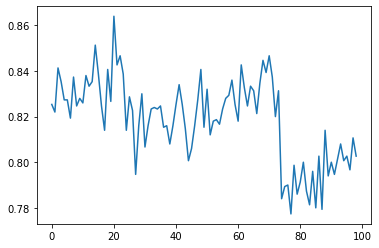

0.818781
0.010943


In [54]:
IE_single_parm.update(GBDT_pram)

dataset_name = 'SEAa'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_eGBDT,
              **IE_single_parm)

0 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 15.51it/s]


Num tree at the end,279
Total acc,  0.6388888888888888
1 / 15


#batch: 100%|██████████| 99/99 [00:28<00:00,  3.53it/s]


Num tree at the end,210
Total acc,  0.5747474747474748
2 / 15


#batch: 100%|██████████| 99/99 [00:10<00:00,  9.38it/s]


Num tree at the end,351
Total acc,  0.6723232323232323
3 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 14.12it/s]


Num tree at the end,387
Total acc,  0.6938383838383838
4 / 15


#batch: 100%|██████████| 99/99 [00:56<00:00,  1.76it/s]


Num tree at the end,205
Total acc,  0.548989898989899
5 / 15


#batch: 100%|██████████| 99/99 [00:47<00:00,  2.08it/s]


Num tree at the end,205
Total acc,  0.5595959595959596
6 / 15


#batch: 100%|██████████| 99/99 [00:42<00:00,  2.32it/s]


Num tree at the end,215
Total acc,  0.5607070707070707
7 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 14.70it/s]


Num tree at the end,333
Total acc,  0.7486868686868687
8 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 12.85it/s]


Num tree at the end,497
Total acc,  0.7252525252525253
9 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.01it/s]


Num tree at the end,210
Total acc,  0.6174747474747475
10 / 15


#batch: 100%|██████████| 99/99 [00:11<00:00,  8.41it/s]


Num tree at the end,377
Total acc,  0.6903030303030303
11 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 15.18it/s]


Num tree at the end,306
Total acc,  0.6956565656565656
12 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 16.38it/s]


Num tree at the end,274
Total acc,  0.6128282828282828
13 / 15


#batch: 100%|██████████| 99/99 [00:14<00:00,  7.06it/s]


Num tree at the end,347
Total acc,  0.696969696969697
14 / 15


#batch: 100%|██████████| 99/99 [00:10<00:00,  9.14it/s]


Num tree at the end,235
Total acc,  0.6537373737373737
0.646000
0.062229


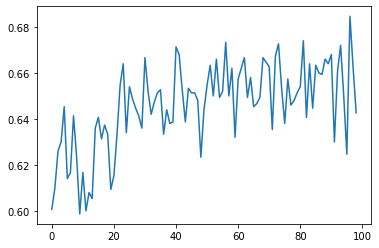

0.646000
0.062229


In [55]:
IE_single_parm.update(GBDT_pram)

dataset_name = 'RTG'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_eGBDT,
              **IE_single_parm)



0 / 15


#batch: 100%|██████████| 99/99 [00:08<00:00, 11.88it/s]


Num tree at the end,667
Total acc,  0.8278787878787879
1 / 15


#batch: 100%|██████████| 99/99 [00:08<00:00, 12.03it/s]


Num tree at the end,639
Total acc,  0.784949494949495
2 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 12.54it/s]


Num tree at the end,612
Total acc,  0.7633333333333333
3 / 15


#batch: 100%|██████████| 99/99 [00:08<00:00, 12.09it/s]


Num tree at the end,624
Total acc,  0.8091919191919192
4 / 15


#batch: 100%|██████████| 99/99 [00:08<00:00, 11.79it/s]


Num tree at the end,675
Total acc,  0.8180808080808081
5 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 12.46it/s]


Num tree at the end,585
Total acc,  0.7605050505050505
6 / 15


#batch: 100%|██████████| 99/99 [00:09<00:00, 10.31it/s]


Num tree at the end,675
Total acc,  0.7774747474747474
7 / 15


#batch: 100%|██████████| 99/99 [00:08<00:00, 11.76it/s]


Num tree at the end,679
Total acc,  0.8324242424242424
8 / 15


#batch: 100%|██████████| 99/99 [00:08<00:00, 11.73it/s]


Num tree at the end,677
Total acc,  0.8207070707070707
9 / 15


#batch: 100%|██████████| 99/99 [00:08<00:00, 11.93it/s]


Num tree at the end,639
Total acc,  0.838989898989899
10 / 15


#batch: 100%|██████████| 99/99 [00:08<00:00, 11.85it/s]


Num tree at the end,666
Total acc,  0.7976767676767677
11 / 15


#batch: 100%|██████████| 99/99 [00:08<00:00, 11.74it/s]


Num tree at the end,682
Total acc,  0.8161616161616162
12 / 15


#batch: 100%|██████████| 99/99 [00:08<00:00, 11.91it/s]


Num tree at the end,647
Total acc,  0.8282828282828283
13 / 15


#batch: 100%|██████████| 99/99 [00:08<00:00, 11.92it/s]


Num tree at the end,659
Total acc,  0.7855555555555556
14 / 15


#batch: 100%|██████████| 99/99 [00:08<00:00, 12.02it/s]


Num tree at the end,656
Total acc,  0.8426262626262626
0.806923
0.026077


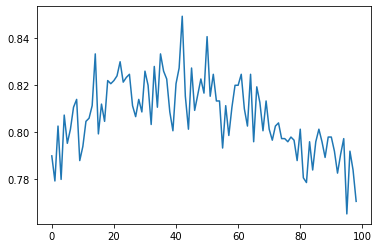

0.806923
0.026077


In [56]:
IE_single_parm.update(GBDT_pram)

dataset_name = 'RBF'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_eGBDT,
              **IE_single_parm)

0 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 13.06it/s]


Num tree at the end,417
Total acc,  0.8107070707070707
1 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 13.53it/s]


Num tree at the end,412
Total acc,  0.7835353535353535
2 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 15.42it/s]


Num tree at the end,288
Total acc,  0.7622222222222222
3 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 12.57it/s]


Num tree at the end,546
Total acc,  0.8016161616161617
4 / 15


#batch: 100%|██████████| 99/99 [00:08<00:00, 11.22it/s]


Num tree at the end,482
Total acc,  0.7806060606060606
5 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 14.36it/s]


Num tree at the end,421
Total acc,  0.7161616161616161
6 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 13.14it/s]


Num tree at the end,454
Total acc,  0.786060606060606
7 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 12.73it/s]


Num tree at the end,512
Total acc,  0.8218181818181818
8 / 15


#batch: 100%|██████████| 99/99 [00:09<00:00, 10.00it/s]


Num tree at the end,477
Total acc,  0.8036363636363636
9 / 15


#batch: 100%|██████████| 99/99 [00:08<00:00, 11.10it/s]


Num tree at the end,462
Total acc,  0.7885858585858586
10 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 12.86it/s]


Num tree at the end,477
Total acc,  0.7966666666666666
11 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 12.89it/s]


Num tree at the end,549
Total acc,  0.806060606060606
12 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 13.24it/s]


Num tree at the end,461
Total acc,  0.8148484848484848
13 / 15


#batch: 100%|██████████| 99/99 [00:09<00:00, 10.11it/s]


Num tree at the end,417
Total acc,  0.7477777777777778
14 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 13.60it/s]


Num tree at the end,390
Total acc,  0.815050505050505
0.789024
0.027627


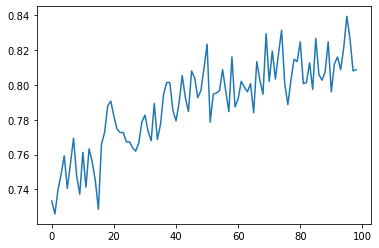

0.789024
0.027627


In [57]:
IE_single_parm.update(GBDT_pram)

dataset_name = 'RBFr'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_eGBDT,
              **IE_single_parm)

0 / 15


#batch: 100%|██████████| 99/99 [00:12<00:00,  8.09it/s]


Num tree at the end,293
Total acc,  0.8245454545454546
1 / 15


#batch: 100%|██████████| 99/99 [00:09<00:00, 10.06it/s]


Num tree at the end,293
Total acc,  0.832929292929293
2 / 15


#batch: 100%|██████████| 99/99 [00:09<00:00, 10.14it/s]


Num tree at the end,300
Total acc,  0.8466666666666667
3 / 15


#batch: 100%|██████████| 99/99 [00:11<00:00,  8.94it/s]


Num tree at the end,301
Total acc,  0.8031313131313131
4 / 15


#batch: 100%|██████████| 99/99 [00:09<00:00, 10.09it/s]


Num tree at the end,297
Total acc,  0.834949494949495
5 / 15


#batch: 100%|██████████| 99/99 [00:09<00:00, 10.08it/s]


Num tree at the end,288
Total acc,  0.8408080808080808
6 / 15


#batch: 100%|██████████| 99/99 [00:14<00:00,  6.73it/s]


Num tree at the end,309
Total acc,  0.835050505050505
7 / 15


#batch: 100%|██████████| 99/99 [00:11<00:00,  8.95it/s]


Num tree at the end,285
Total acc,  0.8258585858585858
8 / 15


#batch: 100%|██████████| 99/99 [00:09<00:00, 10.11it/s]


Num tree at the end,287
Total acc,  0.8241414141414142
9 / 15


#batch: 100%|██████████| 99/99 [00:09<00:00, 10.04it/s]


Num tree at the end,303
Total acc,  0.8344444444444444
10 / 15


#batch: 100%|██████████| 99/99 [00:09<00:00, 10.01it/s]


Num tree at the end,317
Total acc,  0.8331313131313132
11 / 15


#batch: 100%|██████████| 99/99 [00:09<00:00, 10.03it/s]


Num tree at the end,306
Total acc,  0.842020202020202
12 / 15


#batch: 100%|██████████| 99/99 [00:11<00:00,  8.92it/s]


Num tree at the end,302
Total acc,  0.8323232323232324
13 / 15


#batch: 100%|██████████| 99/99 [00:09<00:00, 10.08it/s]


Num tree at the end,297
Total acc,  0.8226262626262626
14 / 15


#batch: 100%|██████████| 99/99 [00:09<00:00, 10.05it/s]

Num tree at the end,306
Total acc,  0.826060606060606
0.830579
0.010002


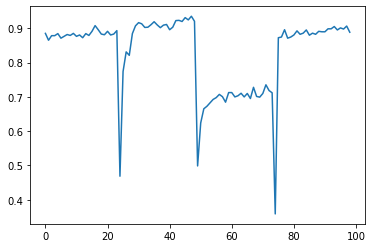

0.830579
0.010002


In [58]:
IE_single_parm.update(GBDT_pram)

dataset_name = 'AGRa'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_eGBDT,
              **IE_single_parm)

0 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 14.14it/s]


Num tree at the end,316
Total acc,  0.7529292929292929
1 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 13.11it/s]


Num tree at the end,435
Total acc,  0.7945454545454546
2 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 14.58it/s]


Num tree at the end,333
Total acc,  0.7705050505050505
3 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 14.36it/s]


Num tree at the end,317
Total acc,  0.7666666666666667
4 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 13.50it/s]


Num tree at the end,403
Total acc,  0.7732323232323233
5 / 15


#batch: 100%|██████████| 99/99 [00:06<00:00, 14.29it/s]


Num tree at the end,332
Total acc,  0.758989898989899
6 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 13.86it/s]


Num tree at the end,371
Total acc,  0.7885858585858586
7 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 13.61it/s]


Num tree at the end,385
Total acc,  0.7747474747474747
8 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 13.89it/s]


Num tree at the end,347
Total acc,  0.777070707070707
9 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 13.44it/s]


Num tree at the end,367
Total acc,  0.7425252525252525
10 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 13.99it/s]


Num tree at the end,345
Total acc,  0.765959595959596
11 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 12.98it/s]


Num tree at the end,439
Total acc,  0.7607070707070707
12 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 14.07it/s]


Num tree at the end,362
Total acc,  0.7684848484848484
13 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 13.63it/s]


Num tree at the end,394
Total acc,  0.7626262626262627
14 / 15


#batch: 100%|██████████| 99/99 [00:07<00:00, 13.30it/s]


Num tree at the end,421
Total acc,  0.7612121212121212
0.767919
0.012600


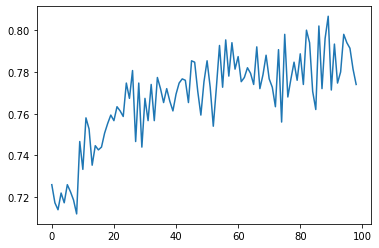

0.767919
0.012600


In [59]:
IE_single_parm.update(GBDT_pram)

dataset_name = 'HYP'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_eGBDT,
              **IE_single_parm)

### AdIter

0 / 15


#batch: 100%|██████████| 99/99 [02:51<00:00,  1.74s/it]


Total acc,  0.8307070707070707
1 / 15


#batch: 100%|██████████| 99/99 [02:57<00:00,  1.79s/it]


Total acc,  0.8362626262626263
2 / 15


#batch: 100%|██████████| 99/99 [02:58<00:00,  1.80s/it]


Total acc,  0.8466666666666667
3 / 15


#batch: 100%|██████████| 99/99 [02:52<00:00,  1.74s/it]


Total acc,  0.8268686868686869
4 / 15


#batch: 100%|██████████| 99/99 [02:50<00:00,  1.72s/it]


Total acc,  0.8321212121212122
5 / 15


#batch: 100%|██████████| 99/99 [02:56<00:00,  1.78s/it]


Total acc,  0.8408080808080808
6 / 15


#batch: 100%|██████████| 99/99 [02:54<00:00,  1.77s/it]


Total acc,  0.8382828282828283
7 / 15


#batch: 100%|██████████| 99/99 [02:53<00:00,  1.75s/it]


Total acc,  0.8316161616161616
8 / 15


#batch: 100%|██████████| 99/99 [02:52<00:00,  1.74s/it]


Total acc,  0.832020202020202
9 / 15


#batch: 100%|██████████| 99/99 [02:54<00:00,  1.76s/it]


Total acc,  0.8327272727272728
10 / 15


#batch: 100%|██████████| 99/99 [02:58<00:00,  1.80s/it]


Total acc,  0.8465656565656565
11 / 15


#batch: 100%|██████████| 99/99 [02:53<00:00,  1.76s/it]


Total acc,  0.841010101010101
12 / 15


#batch: 100%|██████████| 99/99 [02:51<00:00,  1.73s/it]


Total acc,  0.8257575757575758
13 / 15


#batch: 100%|██████████| 99/99 [02:51<00:00,  1.73s/it]


Total acc,  0.8184848484848485
14 / 15


#batch: 100%|██████████| 99/99 [02:55<00:00,  1.78s/it]

Total acc,  0.8371717171717171
0.834471
0.007435


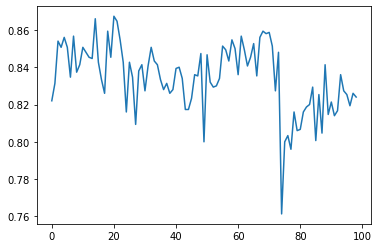

0.834471
0.007435


In [78]:
###AdIter
AdIter_parm = {
    'ini_train_size': 100,
    'win_size': 100,
    'max_tree': 10000,
    'max_num_inc_tree': 125, 
    'gap_num_inc_tree': 25
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4,
}

AdIter_parm.update(GBDT_pram)
dataset_name = 'SEAa'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_AdIter, **AdIter_parm
             )

0 / 15


#batch: 100%|██████████| 99/99 [03:02<00:00,  1.85s/it]


Total acc,  0.6756565656565656
1 / 15


#batch: 100%|██████████| 99/99 [03:18<00:00,  2.01s/it]


Total acc,  0.6259595959595959
2 / 15


#batch: 100%|██████████| 99/99 [03:01<00:00,  1.84s/it]


Total acc,  0.674040404040404
3 / 15


#batch: 100%|██████████| 99/99 [03:00<00:00,  1.82s/it]


Total acc,  0.7160606060606061
4 / 15


#batch: 100%|██████████| 99/99 [04:39<00:00,  2.83s/it]


Total acc,  0.5638383838383838
5 / 15


#batch: 100%|██████████| 99/99 [03:18<00:00,  2.00s/it]


Total acc,  0.6031313131313132
6 / 15


#batch: 100%|██████████| 99/99 [03:48<00:00,  2.31s/it]


Total acc,  0.6054545454545455
7 / 15


#batch: 100%|██████████| 99/99 [03:03<00:00,  1.85s/it]


Total acc,  0.7801010101010101
8 / 15


#batch: 100%|██████████| 99/99 [03:12<00:00,  1.94s/it]


Total acc,  0.7988888888888889
9 / 15


#batch: 100%|██████████| 99/99 [03:27<00:00,  2.09s/it]


Total acc,  0.6652525252525252
10 / 15


#batch: 100%|██████████| 99/99 [03:00<00:00,  1.83s/it]


Total acc,  0.7156565656565657
11 / 15


#batch: 100%|██████████| 99/99 [03:02<00:00,  1.84s/it]


Total acc,  0.7256565656565657
12 / 15


#batch: 100%|██████████| 99/99 [02:55<00:00,  1.78s/it]


Total acc,  0.627979797979798
13 / 15


#batch: 100%|██████████| 99/99 [03:12<00:00,  1.94s/it]


Total acc,  0.7
14 / 15


#batch: 100%|██████████| 99/99 [03:09<00:00,  1.91s/it]

Total acc,  0.6774747474747475
0.677010
0.063214


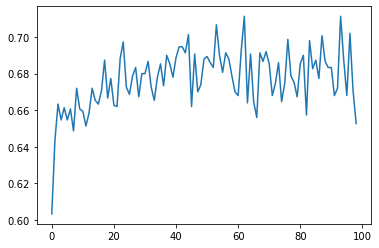

0.677010
0.063214


In [79]:
###AdIter
AdIter_parm = {
    'ini_train_size': 100,
    'win_size': 100,
    'max_tree': 10000,
    'max_num_inc_tree': 125, 
    'gap_num_inc_tree': 25
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4,
}

AdIter_parm.update(GBDT_pram)
dataset_name = 'RTG'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_AdIter, **AdIter_parm
             )

0 / 15


#batch: 100%|██████████| 99/99 [03:52<00:00,  2.35s/it]


Total acc,  0.8925252525252525
1 / 15


#batch: 100%|██████████| 99/99 [03:47<00:00,  2.30s/it]


Total acc,  0.8457575757575757
2 / 15


#batch: 100%|██████████| 99/99 [03:32<00:00,  2.14s/it]


Total acc,  0.8361616161616162
3 / 15


#batch: 100%|██████████| 99/99 [03:48<00:00,  2.31s/it]


Total acc,  0.8604040404040404
4 / 15


#batch: 100%|██████████| 99/99 [03:56<00:00,  2.39s/it]


Total acc,  0.863030303030303
5 / 15


#batch: 100%|██████████| 99/99 [03:37<00:00,  2.20s/it]


Total acc,  0.8171717171717172
6 / 15


#batch: 100%|██████████| 99/99 [04:00<00:00,  2.43s/it]


Total acc,  0.8568686868686869
7 / 15


#batch: 100%|██████████| 99/99 [04:00<00:00,  2.43s/it]


Total acc,  0.8764646464646465
8 / 15


#batch: 100%|██████████| 99/99 [03:46<00:00,  2.28s/it]


Total acc,  0.8544444444444445
9 / 15


#batch: 100%|██████████| 99/99 [03:39<00:00,  2.22s/it]


Total acc,  0.8703030303030304
10 / 15


#batch: 100%|██████████| 99/99 [03:51<00:00,  2.34s/it]


Total acc,  0.8357575757575758
11 / 15


#batch: 100%|██████████| 99/99 [04:03<00:00,  2.46s/it]


Total acc,  0.8768686868686869
12 / 15


#batch: 100%|██████████| 99/99 [03:38<00:00,  2.20s/it]


Total acc,  0.8666666666666667
13 / 15


#batch: 100%|██████████| 99/99 [03:39<00:00,  2.22s/it]


Total acc,  0.8295959595959596
14 / 15


#batch: 100%|██████████| 99/99 [03:38<00:00,  2.21s/it]

Total acc,  0.8740404040404041
0.857071
0.020000


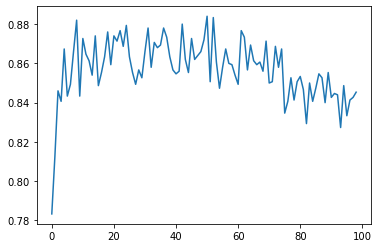

0.857071
0.020000


In [80]:
###AdIter
AdIter_parm = {
    'ini_train_size': 100,
    'win_size': 100,
    'max_tree': 10000,
    'max_num_inc_tree': 125, 
    'gap_num_inc_tree': 25
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4,
}

AdIter_parm.update(GBDT_pram)
dataset_name = 'RBF'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_AdIter, **AdIter_parm
             )

0 / 15


#batch: 100%|██████████| 99/99 [03:10<00:00,  1.93s/it]


Total acc,  0.8363636363636363
1 / 15


#batch: 100%|██████████| 99/99 [03:06<00:00,  1.88s/it]


Total acc,  0.8098989898989899
2 / 15


#batch: 100%|██████████| 99/99 [02:54<00:00,  1.77s/it]


Total acc,  0.7746464646464647
3 / 15


#batch: 100%|██████████| 99/99 [03:11<00:00,  1.93s/it]


Total acc,  0.8225252525252525
4 / 15


#batch: 100%|██████████| 99/99 [03:13<00:00,  1.96s/it]


Total acc,  0.8136363636363636
5 / 15


#batch: 100%|██████████| 99/99 [03:07<00:00,  1.89s/it]


Total acc,  0.7701010101010101
6 / 15


#batch: 100%|██████████| 99/99 [03:07<00:00,  1.89s/it]


Total acc,  0.8233333333333334
7 / 15


#batch: 100%|██████████| 99/99 [03:11<00:00,  1.94s/it]


Total acc,  0.848989898989899
8 / 15


#batch: 100%|██████████| 99/99 [03:14<00:00,  1.96s/it]


Total acc,  0.8301010101010101
9 / 15


#batch: 100%|██████████| 99/99 [03:12<00:00,  1.95s/it]


Total acc,  0.8276767676767677
10 / 15


#batch: 100%|██████████| 99/99 [03:10<00:00,  1.93s/it]


Total acc,  0.8011111111111111
11 / 15


#batch: 100%|██████████| 99/99 [03:13<00:00,  1.95s/it]


Total acc,  0.8457575757575757
12 / 15


#batch: 100%|██████████| 99/99 [03:03<00:00,  1.86s/it]


Total acc,  0.8275757575757576
13 / 15


#batch: 100%|██████████| 99/99 [03:09<00:00,  1.91s/it]


Total acc,  0.7907070707070707
14 / 15


#batch: 100%|██████████| 99/99 [03:05<00:00,  1.88s/it]

Total acc,  0.8276767676767677
0.816673
0.022810


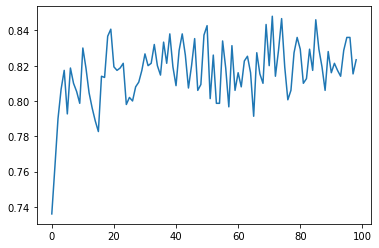

0.816673
0.022810


In [81]:
###AdIter
AdIter_parm = {
    'ini_train_size': 100,
    'win_size': 100,
    'max_tree': 10000,
    'max_num_inc_tree': 125, 
    'gap_num_inc_tree': 25
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4,
}

AdIter_parm.update(GBDT_pram)
dataset_name = 'RBFr'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_AdIter, **AdIter_parm
             )

0 / 15


#batch: 100%|██████████| 99/99 [03:08<00:00,  1.90s/it]


Total acc,  0.8443434343434344
1 / 15


#batch: 100%|██████████| 99/99 [03:12<00:00,  1.94s/it]


Total acc,  0.853030303030303
2 / 15


#batch: 100%|██████████| 99/99 [03:06<00:00,  1.88s/it]


Total acc,  0.8378787878787879
3 / 15


#batch: 100%|██████████| 99/99 [03:09<00:00,  1.91s/it]


Total acc,  0.8342424242424242
4 / 15


#batch: 100%|██████████| 99/99 [03:09<00:00,  1.92s/it]


Total acc,  0.8381818181818181
5 / 15


#batch: 100%|██████████| 99/99 [03:05<00:00,  1.87s/it]


Total acc,  0.8522222222222222
6 / 15


#batch: 100%|██████████| 99/99 [03:10<00:00,  1.92s/it]


Total acc,  0.8454545454545455
7 / 15


#batch: 100%|██████████| 99/99 [03:10<00:00,  1.93s/it]


Total acc,  0.8523232323232324
8 / 15


#batch: 100%|██████████| 99/99 [03:08<00:00,  1.90s/it]


Total acc,  0.8434343434343434
9 / 15


#batch: 100%|██████████| 99/99 [03:16<00:00,  1.98s/it]


Total acc,  0.8295959595959596
10 / 15


#batch: 100%|██████████| 99/99 [03:08<00:00,  1.90s/it]


Total acc,  0.8594949494949495
11 / 15


#batch: 100%|██████████| 99/99 [03:11<00:00,  1.94s/it]


Total acc,  0.8445454545454546
12 / 15


#batch: 100%|██████████| 99/99 [03:04<00:00,  1.86s/it]


Total acc,  0.8461616161616161
13 / 15


#batch: 100%|██████████| 99/99 [03:06<00:00,  1.88s/it]


Total acc,  0.8485858585858586
14 / 15


#batch: 100%|██████████| 99/99 [03:12<00:00,  1.95s/it]

Total acc,  0.8491919191919192
0.845246
0.007593


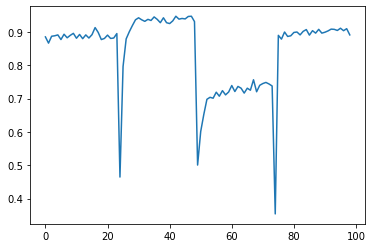

0.845246
0.007593


In [82]:
###AdIter
AdIter_parm = {
    'ini_train_size': 100,
    'win_size': 100,
    'max_tree': 10000,
    'max_num_inc_tree': 125, 
    'gap_num_inc_tree': 25
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4,
}

AdIter_parm.update(GBDT_pram)
dataset_name = 'AGRa'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_AdIter, **AdIter_parm
             )

0 / 15


#batch: 100%|██████████| 99/99 [03:01<00:00,  1.84s/it]


Total acc,  0.769090909090909
1 / 15


#batch: 100%|██████████| 99/99 [03:03<00:00,  1.86s/it]


Total acc,  0.8133333333333334
2 / 15


#batch: 100%|██████████| 99/99 [02:59<00:00,  1.81s/it]


Total acc,  0.7881818181818182
3 / 15


#batch: 100%|██████████| 99/99 [02:58<00:00,  1.80s/it]


Total acc,  0.7853535353535354
4 / 15


#batch: 100%|██████████| 99/99 [03:04<00:00,  1.86s/it]


Total acc,  0.7795959595959596
5 / 15


#batch: 100%|██████████| 99/99 [02:59<00:00,  1.82s/it]


Total acc,  0.7852525252525252
6 / 15


#batch: 100%|██████████| 99/99 [03:00<00:00,  1.82s/it]


Total acc,  0.7904040404040404
7 / 15


#batch: 100%|██████████| 99/99 [03:00<00:00,  1.83s/it]


Total acc,  0.7877777777777778
8 / 15


#batch: 100%|██████████| 99/99 [03:01<00:00,  1.84s/it]


Total acc,  0.7975757575757576
9 / 15


#batch: 100%|██████████| 99/99 [03:02<00:00,  1.84s/it]


Total acc,  0.7598989898989899
10 / 15


#batch: 100%|██████████| 99/99 [02:59<00:00,  1.81s/it]


Total acc,  0.7808080808080808
11 / 15


#batch: 100%|██████████| 99/99 [03:04<00:00,  1.87s/it]


Total acc,  0.778080808080808
12 / 15


#batch: 100%|██████████| 99/99 [03:00<00:00,  1.82s/it]


Total acc,  0.778989898989899
13 / 15


#batch: 100%|██████████| 99/99 [03:02<00:00,  1.84s/it]


Total acc,  0.785959595959596
14 / 15


#batch: 100%|██████████| 99/99 [03:02<00:00,  1.85s/it]

Total acc,  0.7866666666666666
0.784465
0.011609


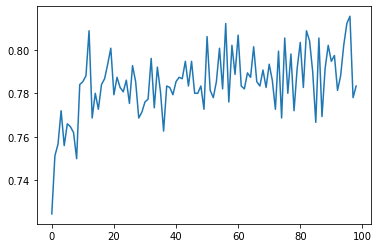

0.784465
0.011609


In [83]:
###AdIter
AdIter_parm = {
    'ini_train_size': 100,
    'win_size': 100,
    'max_tree': 10000,
    'max_num_inc_tree': 125, 
    'gap_num_inc_tree': 25
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4,
}

AdIter_parm.update(GBDT_pram)
dataset_name = 'HYP'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_AdIter, **AdIter_parm
             )

### GBDT base

0 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 79.28it/s]


Total acc,  0.802020202020202
1 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 79.61it/s]


Total acc,  0.788080808080808
2 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 79.42it/s]


Total acc,  0.7941414141414141
3 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 79.15it/s]


Total acc,  0.7946464646464646
4 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 79.48it/s]


Total acc,  0.8154545454545454
5 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 79.60it/s]


Total acc,  0.8088888888888889
6 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 79.77it/s]


Total acc,  0.821010101010101
7 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 80.31it/s]


Total acc,  0.8038383838383838
8 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 80.03it/s]


Total acc,  0.7631313131313131
9 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 79.92it/s]


Total acc,  0.8013131313131313
10 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 79.73it/s]


Total acc,  0.7737373737373737
11 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 79.70it/s]


Total acc,  0.8098989898989899
12 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 79.61it/s]


Total acc,  0.7805050505050505
13 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 79.45it/s]


Total acc,  0.7816161616161617
14 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 79.53it/s]


Total acc,  0.8086868686868687
0.796465
0.015786


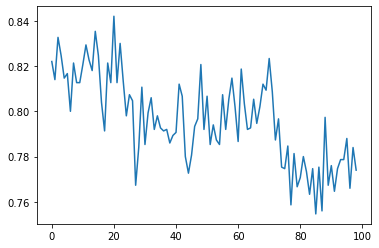

0.796465
0.015786


In [34]:
GBDT_base = {
    'ini_train_size': 100,
    'win_size': 100,
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4
}

GBDT_base.update(GBDT_pram)
dataset_name = 'SEAa'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_baseline_GBDT,
              **GBDT_base)

0 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.12it/s]


Total acc,  0.6168686868686869
1 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.59it/s]


Total acc,  0.553939393939394
2 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.28it/s]


Total acc,  0.6183838383838384
3 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 77.90it/s]


Total acc,  0.6563636363636364
4 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.13it/s]


Total acc,  0.5198989898989899
5 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.25it/s]


Total acc,  0.5204040404040404
6 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.57it/s]


Total acc,  0.5619191919191919
7 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 77.79it/s]


Total acc,  0.7194949494949495
8 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.21it/s]


Total acc,  0.598989898989899
9 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.03it/s]


Total acc,  0.6116161616161616
10 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.55it/s]


Total acc,  0.622020202020202
11 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.02it/s]


Total acc,  0.6597979797979798
12 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 77.90it/s]


Total acc,  0.5941414141414142
13 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.00it/s]


Total acc,  0.6145454545454545
14 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.23it/s]


Total acc,  0.6262626262626263
0.606310
0.050949


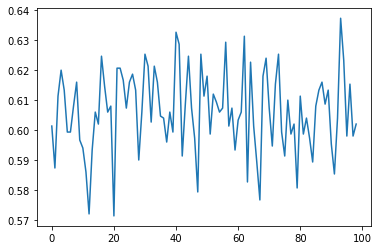

0.606310
0.050949


In [35]:
GBDT_base = {
    'ini_train_size': 100,
    'win_size': 100,
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4
}

GBDT_base.update(GBDT_pram)
dataset_name = 'RTG'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_baseline_GBDT,
              **GBDT_base)

0 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.25it/s]


Total acc,  0.7031313131313132
1 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.47it/s]


Total acc,  0.6742424242424242
2 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.52it/s]


Total acc,  0.6868686868686869
3 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.26it/s]


Total acc,  0.7160606060606061
4 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.59it/s]


Total acc,  0.6225252525252525
5 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.19it/s]


Total acc,  0.6756565656565656
6 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.62it/s]


Total acc,  0.6695959595959596
7 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.57it/s]


Total acc,  0.6341414141414141
8 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.38it/s]


Total acc,  0.6671717171717172
9 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.26it/s]


Total acc,  0.74989898989899
10 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.44it/s]


Total acc,  0.6309090909090909
11 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.41it/s]


Total acc,  0.6237373737373737
12 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.50it/s]


Total acc,  0.7390909090909091
13 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.46it/s]


Total acc,  0.6519191919191919
14 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.31it/s]


Total acc,  0.656060606060606
0.673401
0.038536


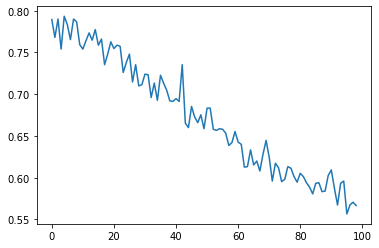

0.673401
0.038536


In [36]:
GBDT_base = {
    'ini_train_size': 100,
    'win_size': 100,
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4
}

GBDT_base.update(GBDT_pram)
dataset_name = 'RBF'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_baseline_GBDT,
              **GBDT_base)

0 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.12it/s]


Total acc,  0.7337373737373737
1 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 77.64it/s]


Total acc,  0.730909090909091
2 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.16it/s]


Total acc,  0.7545454545454545
3 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.34it/s]


Total acc,  0.7316161616161616
4 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.98it/s]


Total acc,  0.7124242424242424
5 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.52it/s]


Total acc,  0.675959595959596
6 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.40it/s]


Total acc,  0.7045454545454546
7 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.29it/s]


Total acc,  0.7642424242424243
8 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.02it/s]


Total acc,  0.7025252525252526
9 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.09it/s]


Total acc,  0.7486868686868687
10 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.39it/s]


Total acc,  0.7313131313131314
11 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.24it/s]


Total acc,  0.7397979797979798
12 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.14it/s]


Total acc,  0.7465656565656565
13 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.27it/s]


Total acc,  0.6952525252525252
14 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 77.82it/s]


Total acc,  0.7848484848484848
0.730465
0.027518


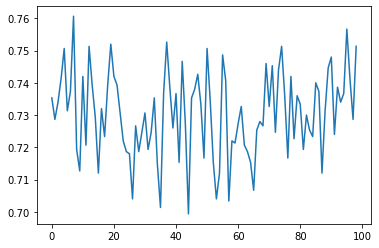

0.730465
0.027518


In [37]:
GBDT_base = {
    'ini_train_size': 100,
    'win_size': 100,
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4
}

GBDT_base.update(GBDT_pram)
dataset_name = 'RBFr'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_baseline_GBDT,
              **GBDT_base)

0 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.69it/s]


Total acc,  0.5880808080808081
1 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.58it/s]


Total acc,  0.585959595959596
2 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.97it/s]


Total acc,  0.583030303030303
3 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.52it/s]


Total acc,  0.5753535353535354
4 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.55it/s]


Total acc,  0.585959595959596
5 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.52it/s]


Total acc,  0.5883838383838383
6 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.79it/s]


Total acc,  0.5838383838383838
7 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.65it/s]


Total acc,  0.5825252525252526
8 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.54it/s]


Total acc,  0.5880808080808081
9 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.36it/s]


Total acc,  0.5903030303030303
10 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.74it/s]


Total acc,  0.5673737373737374
11 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.40it/s]


Total acc,  0.5791919191919191
12 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.50it/s]


Total acc,  0.5732323232323232
13 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.74it/s]


Total acc,  0.5801010101010101
14 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.55it/s]


Total acc,  0.5821212121212122
0.582236
0.006139


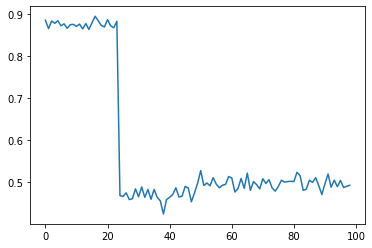

0.582236
0.006139


In [38]:
GBDT_base = {
    'ini_train_size': 100,
    'win_size': 100,
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4
}

GBDT_base.update(GBDT_pram)
dataset_name = 'AGRa'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_baseline_GBDT,
              **GBDT_base)

0 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.57it/s]


Total acc,  0.6876767676767677
1 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.35it/s]


Total acc,  0.6898989898989899
2 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.03it/s]


Total acc,  0.74989898989899
3 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.09it/s]


Total acc,  0.7152525252525253
4 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.07it/s]


Total acc,  0.6928282828282828
5 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.09it/s]


Total acc,  0.7087878787878787
6 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.24it/s]


Total acc,  0.7194949494949495
7 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.38it/s]


Total acc,  0.6883838383838384
8 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.10it/s]


Total acc,  0.7182828282828283
9 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.14it/s]


Total acc,  0.6566666666666666
10 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.24it/s]


Total acc,  0.7121212121212122
11 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.32it/s]


Total acc,  0.6456565656565657
12 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.02it/s]


Total acc,  0.7224242424242424
13 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.29it/s]


Total acc,  0.7155555555555555
14 / 15


#batch: 100%|██████████| 99/99 [00:01<00:00, 78.27it/s]


Total acc,  0.6630303030303031
0.699064
0.027118


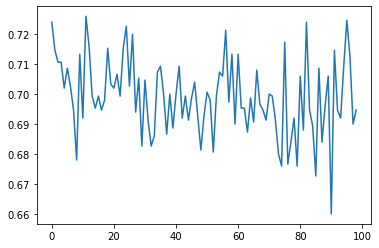

0.699064
0.027118


In [39]:
GBDT_base = {
    'ini_train_size': 100,
    'win_size': 100,
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4
}

GBDT_base.update(GBDT_pram)
dataset_name = 'HYP'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_baseline_GBDT,
              **GBDT_base)

### Slide GBDT

0 / 15


#batch: 100%|██████████| 99/99 [02:04<00:00,  1.26s/it]


Total acc,  0.7923232323232323
1 / 15


#batch: 100%|██████████| 99/99 [02:04<00:00,  1.26s/it]


Total acc,  0.804949494949495
2 / 15


#batch: 100%|██████████| 99/99 [02:05<00:00,  1.26s/it]


Total acc,  0.8158585858585858
3 / 15


#batch: 100%|██████████| 99/99 [02:04<00:00,  1.26s/it]


Total acc,  0.8052525252525252
4 / 15


#batch: 100%|██████████| 99/99 [02:04<00:00,  1.26s/it]


Total acc,  0.8045454545454546
5 / 15


#batch: 100%|██████████| 99/99 [02:04<00:00,  1.26s/it]


Total acc,  0.8011111111111111
6 / 15


#batch: 100%|██████████| 99/99 [02:04<00:00,  1.26s/it]


Total acc,  0.8057575757575758
7 / 15


#batch: 100%|██████████| 99/99 [02:04<00:00,  1.26s/it]


Total acc,  0.8066666666666666
8 / 15


#batch: 100%|██████████| 99/99 [02:05<00:00,  1.27s/it]


Total acc,  0.8008080808080809
9 / 15


#batch: 100%|██████████| 99/99 [02:04<00:00,  1.26s/it]


Total acc,  0.803939393939394
10 / 15


#batch: 100%|██████████| 99/99 [02:04<00:00,  1.26s/it]


Total acc,  0.8125252525252525
11 / 15


#batch: 100%|██████████| 99/99 [02:05<00:00,  1.26s/it]


Total acc,  0.8084848484848485
12 / 15


#batch: 100%|██████████| 99/99 [02:04<00:00,  1.26s/it]


Total acc,  0.8119191919191919
13 / 15


#batch: 100%|██████████| 99/99 [02:04<00:00,  1.26s/it]


Total acc,  0.803939393939394
14 / 15


#batch: 100%|██████████| 99/99 [02:04<00:00,  1.26s/it]

Total acc,  0.8074747474747475
0.805704
0.005370


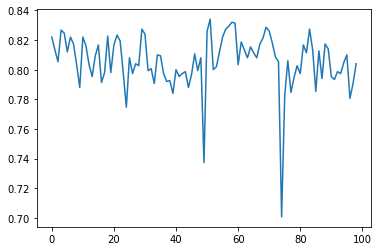

0.805704
0.005370


In [40]:
GBDT_sliding = {
    'ini_train_size': 100,
    'win_size': 100,
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4
}

GBDT_sliding.update(GBDT_pram)
dataset_name = 'SEAa'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_sliding_GBDT,
              **GBDT_sliding)

0 / 15


#batch: 100%|██████████| 99/99 [02:07<00:00,  1.28s/it]


Total acc,  0.6342424242424243
1 / 15


#batch: 100%|██████████| 99/99 [02:07<00:00,  1.28s/it]


Total acc,  0.5546464646464646
2 / 15


#batch: 100%|██████████| 99/99 [02:06<00:00,  1.28s/it]


Total acc,  0.6266666666666667
3 / 15


#batch: 100%|██████████| 99/99 [02:07<00:00,  1.29s/it]


Total acc,  0.6552525252525252
4 / 15


#batch: 100%|██████████| 99/99 [02:07<00:00,  1.28s/it]


Total acc,  0.5432323232323232
5 / 15


#batch: 100%|██████████| 99/99 [02:07<00:00,  1.29s/it]


Total acc,  0.5521212121212121
6 / 15


#batch: 100%|██████████| 99/99 [02:13<00:00,  1.35s/it]


Total acc,  0.5564646464646464
7 / 15


#batch: 100%|██████████| 99/99 [02:07<00:00,  1.28s/it]


Total acc,  0.7258585858585859
8 / 15


#batch: 100%|██████████| 99/99 [02:07<00:00,  1.28s/it]


Total acc,  0.7281818181818182
9 / 15


#batch: 100%|██████████| 99/99 [02:07<00:00,  1.29s/it]


Total acc,  0.5974747474747475
10 / 15


#batch: 100%|██████████| 99/99 [02:07<00:00,  1.29s/it]


Total acc,  0.6625252525252525
11 / 15


#batch: 100%|██████████| 99/99 [02:07<00:00,  1.29s/it]


Total acc,  0.6471717171717172
12 / 15


#batch: 100%|██████████| 99/99 [02:07<00:00,  1.28s/it]


Total acc,  0.5933333333333334
13 / 15


#batch: 100%|██████████| 99/99 [02:07<00:00,  1.28s/it]


Total acc,  0.6537373737373737
14 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.30s/it]

Total acc,  0.6244444444444445
0.623690
0.056525


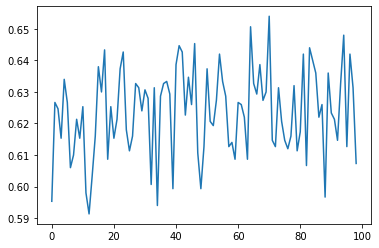

0.623690
0.056525


In [41]:
GBDT_sliding = {
    'ini_train_size': 100,
    'win_size': 100,
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4
}

GBDT_sliding.update(GBDT_pram)
dataset_name = 'RTG'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_sliding_GBDT,
              **GBDT_sliding)

0 / 15


#batch: 100%|██████████| 99/99 [02:10<00:00,  1.32s/it]


Total acc,  0.7946464646464646
1 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.7405050505050506
2 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.7682828282828282
3 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.7619191919191919
4 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.7613131313131313
5 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.30s/it]


Total acc,  0.73989898989899
6 / 15


#batch: 100%|██████████| 99/99 [02:14<00:00,  1.36s/it]


Total acc,  0.7496969696969698
7 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.7896969696969697
8 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.30s/it]


Total acc,  0.7404040404040404
9 / 15


#batch: 100%|██████████| 99/99 [02:07<00:00,  1.29s/it]


Total acc,  0.7733333333333333
10 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.7397979797979798
11 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.7562626262626263
12 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.777070707070707
13 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.7442424242424243
14 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]

Total acc,  0.8115151515151515
0.763239
0.021705


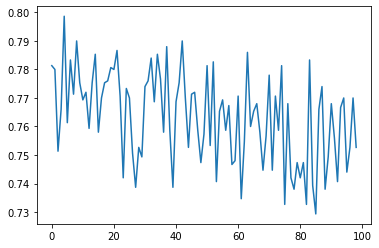

0.763239
0.021705


In [42]:
GBDT_sliding = {
    'ini_train_size': 100,
    'win_size': 100,
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4
}

GBDT_sliding.update(GBDT_pram)
dataset_name = 'RBF'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_sliding_GBDT,
              **GBDT_sliding)

0 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.751010101010101
1 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.7423232323232323
2 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.30s/it]


Total acc,  0.7407070707070708
3 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.30s/it]


Total acc,  0.7546464646464647
4 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.7496969696969698
5 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.7156565656565657
6 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.30s/it]


Total acc,  0.7374747474747475
7 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.776969696969697
8 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.7272727272727273
9 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.7576767676767677
10 / 15


#batch: 100%|██████████| 99/99 [02:07<00:00,  1.29s/it]


Total acc,  0.7265656565656565
11 / 15


#batch: 100%|██████████| 99/99 [02:07<00:00,  1.29s/it]


Total acc,  0.7367676767676767
12 / 15


#batch: 100%|██████████| 99/99 [02:07<00:00,  1.29s/it]


Total acc,  0.7612121212121212
13 / 15


#batch: 100%|██████████| 99/99 [02:07<00:00,  1.29s/it]


Total acc,  0.7198989898989899
14 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]

Total acc,  0.7790909090909091
0.745131
0.018356


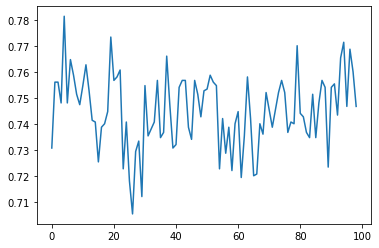

0.745131
0.018356


In [43]:
GBDT_sliding = {
    'ini_train_size': 100,
    'win_size': 100,
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4
}

GBDT_sliding.update(GBDT_pram)
dataset_name = 'RBFr'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_sliding_GBDT,
              **GBDT_sliding)

0 / 15


#batch: 100%|██████████| 99/99 [02:07<00:00,  1.28s/it]


Total acc,  0.8057575757575758
1 / 15


#batch: 100%|██████████| 99/99 [02:06<00:00,  1.28s/it]


Total acc,  0.8086868686868687
2 / 15


#batch: 100%|██████████| 99/99 [02:07<00:00,  1.28s/it]


Total acc,  0.8141414141414142
3 / 15


#batch: 100%|██████████| 99/99 [02:06<00:00,  1.28s/it]


Total acc,  0.8076767676767677
4 / 15


#batch: 100%|██████████| 99/99 [02:06<00:00,  1.28s/it]


Total acc,  0.8109090909090909
5 / 15


#batch: 100%|██████████| 99/99 [02:06<00:00,  1.28s/it]


Total acc,  0.8155555555555556
6 / 15


#batch: 100%|██████████| 99/99 [02:06<00:00,  1.28s/it]


Total acc,  0.8066666666666666
7 / 15


#batch: 100%|██████████| 99/99 [02:06<00:00,  1.28s/it]


Total acc,  0.8008080808080809
8 / 15


#batch: 100%|██████████| 99/99 [02:06<00:00,  1.28s/it]


Total acc,  0.8134343434343434
9 / 15


#batch: 100%|██████████| 99/99 [02:06<00:00,  1.28s/it]


Total acc,  0.7995959595959596
10 / 15


#batch: 100%|██████████| 99/99 [02:06<00:00,  1.28s/it]


Total acc,  0.8135353535353536
11 / 15


#batch: 100%|██████████| 99/99 [02:06<00:00,  1.28s/it]


Total acc,  0.8165656565656566
12 / 15


#batch: 100%|██████████| 99/99 [02:06<00:00,  1.28s/it]


Total acc,  0.807070707070707
13 / 15


#batch: 100%|██████████| 99/99 [02:06<00:00,  1.28s/it]


Total acc,  0.8148484848484848
14 / 15


#batch: 100%|██████████| 99/99 [02:06<00:00,  1.28s/it]

Total acc,  0.8180808080808081
0.810222
0.005427


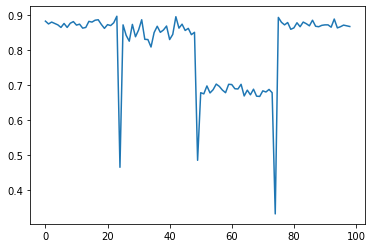

0.810222
0.005427


In [44]:
GBDT_sliding = {
    'ini_train_size': 100,
    'win_size': 100,
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4
}

GBDT_sliding.update(GBDT_pram)
dataset_name = 'AGRa'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_sliding_GBDT,
              **GBDT_sliding)

0 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.7046464646464646
1 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.711919191919192
2 / 15


#batch: 100%|██████████| 99/99 [02:07<00:00,  1.29s/it]


Total acc,  0.7176767676767677
3 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.7126262626262626
4 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.7078787878787879
5 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.6980808080808081
6 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.7002020202020202
7 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.30s/it]


Total acc,  0.7087878787878787
8 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.30s/it]


Total acc,  0.7116161616161616
9 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.30s/it]


Total acc,  0.7
10 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.29s/it]


Total acc,  0.6948484848484848
11 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.30s/it]


Total acc,  0.7076767676767677
12 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.30s/it]


Total acc,  0.7046464646464646
13 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.30s/it]


Total acc,  0.7034343434343434
14 / 15


#batch: 100%|██████████| 99/99 [02:08<00:00,  1.30s/it]

Total acc,  0.7155555555555555
0.706640
0.006393


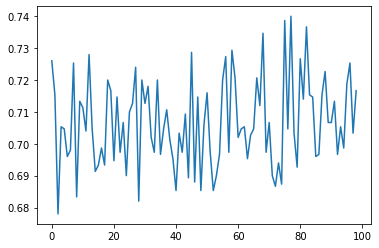

0.706640
0.006393


In [45]:
GBDT_sliding = {
    'ini_train_size': 100,
    'win_size': 100,
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4
}

GBDT_sliding.update(GBDT_pram)
dataset_name = 'HYP'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_sliding_GBDT,
              **GBDT_sliding)

### iGBDT

0 / 15


#batch: 100%|██████████| 99/99 [00:31<00:00,  3.10it/s]


Total acc,  0.8321212121212122
1 / 15


#batch: 100%|██████████| 99/99 [00:31<00:00,  3.12it/s]


Total acc,  0.8337373737373738
2 / 15


#batch: 100%|██████████| 99/99 [00:31<00:00,  3.12it/s]


Total acc,  0.8427272727272728
3 / 15


#batch: 100%|██████████| 99/99 [00:31<00:00,  3.12it/s]


Total acc,  0.8284848484848485
4 / 15


#batch: 100%|██████████| 99/99 [00:31<00:00,  3.12it/s]


Total acc,  0.8298989898989899
5 / 15


#batch: 100%|██████████| 99/99 [00:31<00:00,  3.11it/s]


Total acc,  0.8355555555555556
6 / 15


#batch: 100%|██████████| 99/99 [00:31<00:00,  3.12it/s]


Total acc,  0.8385858585858585
7 / 15


#batch: 100%|██████████| 99/99 [00:31<00:00,  3.12it/s]


Total acc,  0.834949494949495
8 / 15


#batch: 100%|██████████| 99/99 [00:31<00:00,  3.11it/s]


Total acc,  0.8302020202020202
9 / 15


#batch: 100%|██████████| 99/99 [00:31<00:00,  3.12it/s]


Total acc,  0.8318181818181818
10 / 15


#batch: 100%|██████████| 99/99 [00:31<00:00,  3.12it/s]


Total acc,  0.8377777777777777
11 / 15


#batch: 100%|██████████| 99/99 [00:31<00:00,  3.11it/s]


Total acc,  0.841919191919192
12 / 15


#batch: 100%|██████████| 99/99 [00:31<00:00,  3.11it/s]


Total acc,  0.8324242424242424
13 / 15


#batch: 100%|██████████| 99/99 [00:31<00:00,  3.12it/s]


Total acc,  0.8276767676767677
14 / 15


#batch: 100%|██████████| 99/99 [00:31<00:00,  3.12it/s]

Total acc,  0.8391919191919192
0.834471
0.004572


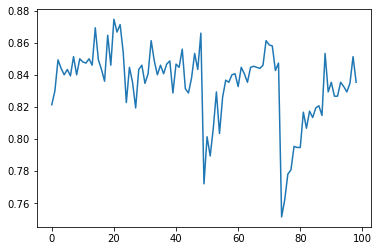

0.834471
0.004572


In [46]:
iGBDT = {
    'ini_train_size': 100,
    'win_size': 100,
    'num_inc_tree': 25
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4
}

iGBDT.update(GBDT_pram)
dataset_name = 'SEAa'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_naive_iGBDT,
              **iGBDT)

0 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.6945454545454546
1 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.639090909090909
2 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.6885858585858586
3 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.7367676767676767
4 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.5971717171717171
5 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.6298989898989898
6 / 15


#batch: 100%|██████████| 99/99 [00:33<00:00,  2.94it/s]


Total acc,  0.6398989898989899
7 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.7797979797979798
8 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.7794949494949495
9 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.04it/s]


Total acc,  0.6973737373737374
10 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.7401010101010101
11 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.04it/s]


Total acc,  0.7267676767676767
12 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.03it/s]


Total acc,  0.6533333333333333
13 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.7208080808080808
14 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.04it/s]

Total acc,  0.6915151515151515
0.694343
0.052626


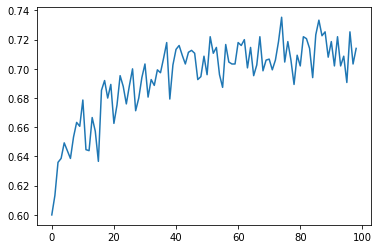

0.694343
0.052626


In [47]:
iGBDT = {
    'ini_train_size': 100,
    'win_size': 100,
    'num_inc_tree': 25
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4
}

iGBDT.update(GBDT_pram)
dataset_name = 'RTG'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_naive_iGBDT,
              **iGBDT)

0 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.8858585858585859
1 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.8365656565656565
2 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.8347474747474748
3 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.8550505050505051
4 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.863030303030303
5 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.04it/s]


Total acc,  0.8152525252525252
6 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.8444444444444444
7 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.8707070707070707
8 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.8508080808080808
9 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.8677777777777778
10 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.04it/s]


Total acc,  0.8332323232323232
11 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.04it/s]


Total acc,  0.8596969696969697
12 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.86
13 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.8244444444444444
14 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.04it/s]

Total acc,  0.8667676767676767
0.851226
0.018735


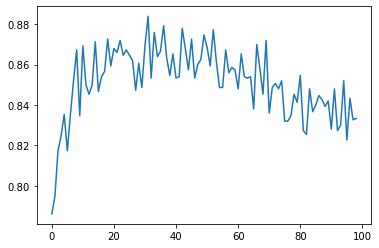

0.851226
0.018735


In [48]:
iGBDT = {
    'ini_train_size': 100,
    'win_size': 100,
    'num_inc_tree': 25
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4
}

iGBDT.update(GBDT_pram)
dataset_name = 'RBF'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_naive_iGBDT,
              **iGBDT)

0 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.04it/s]


Total acc,  0.8344444444444444
1 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.04it/s]


Total acc,  0.812020202020202
2 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.04it/s]


Total acc,  0.7976767676767677
3 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.04it/s]


Total acc,  0.8258585858585858
4 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.8280808080808081
5 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.04it/s]


Total acc,  0.7786868686868686
6 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.808989898989899
7 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.8463636363636363
8 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.8267676767676768
9 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.04it/s]


Total acc,  0.8274747474747475
10 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.8006060606060607
11 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.04it/s]


Total acc,  0.8418181818181818
12 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.8351515151515152
13 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.04it/s]


Total acc,  0.7868686868686868
14 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]

Total acc,  0.8132323232323232
0.817603
0.019380


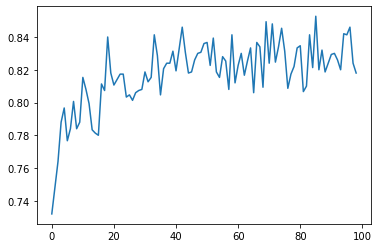

0.817603
0.019380


In [49]:
iGBDT = {
    'ini_train_size': 100,
    'win_size': 100,
    'num_inc_tree': 25
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4
}

iGBDT.update(GBDT_pram)
dataset_name = 'RBFr'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_naive_iGBDT,
              **iGBDT)

0 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.7851515151515152
1 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.04it/s]


Total acc,  0.7917171717171717
2 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.775959595959596
3 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.7831313131313131
4 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.7792929292929293
5 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.03it/s]


Total acc,  0.7915151515151515
6 / 15


#batch: 100%|██████████| 99/99 [00:35<00:00,  2.79it/s]


Total acc,  0.7873737373737374
7 / 15


#batch: 100%|██████████| 99/99 [00:33<00:00,  2.95it/s]


Total acc,  0.7807070707070707
8 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.7818181818181819
9 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.7818181818181819
10 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.7856565656565656
11 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.04it/s]


Total acc,  0.7891919191919192
12 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.04it/s]


Total acc,  0.7847474747474747
13 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]


Total acc,  0.7888888888888889
14 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.05it/s]

Total acc,  0.788080808080808
0.785003
0.004415


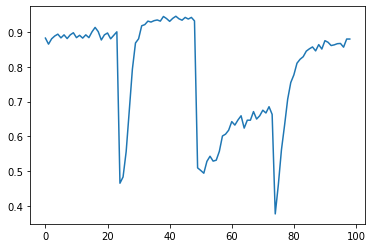

0.785003
0.004415


In [52]:
iGBDT = {
    'ini_train_size': 100,
    'win_size': 100,
    'num_inc_tree': 25
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4
}

iGBDT.update(GBDT_pram)
dataset_name = 'AGRa'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_naive_iGBDT,
              **iGBDT)

0 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.02it/s]


Total acc,  0.7792929292929293
1 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.02it/s]


Total acc,  0.7793939393939394
2 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.03it/s]


Total acc,  0.7918181818181819
3 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.03it/s]


Total acc,  0.7775757575757576
4 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.03it/s]


Total acc,  0.7722222222222223
5 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.03it/s]


Total acc,  0.7820202020202021
6 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.02it/s]


Total acc,  0.7817171717171717
7 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.03it/s]


Total acc,  0.7722222222222223
8 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.02it/s]


Total acc,  0.7843434343434343
9 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.03it/s]


Total acc,  0.7667676767676768
10 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.03it/s]


Total acc,  0.7794949494949495
11 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.04it/s]


Total acc,  0.7767676767676768
12 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.02it/s]


Total acc,  0.7716161616161616
13 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.03it/s]


Total acc,  0.7712121212121212
14 / 15


#batch: 100%|██████████| 99/99 [00:32<00:00,  3.02it/s]

Total acc,  0.7829292929292929
0.777960
0.006179


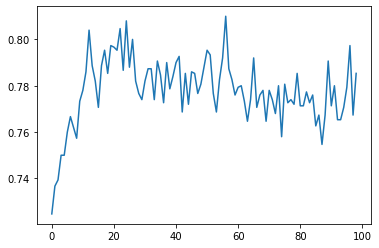

0.777960
0.006179


In [53]:
iGBDT = {
    'ini_train_size': 100,
    'win_size': 100,
    'num_inc_tree': 25
}

GBDT_pram = {
    'max_iter': 200,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 4
}

iGBDT.update(GBDT_pram)
dataset_name = 'HYP'
exp_synthetic(path, dataset_name, num_run, num_eval, evaluation_naive_iGBDT,
              **iGBDT)